# Markov model of the inputs

Objective: find a stochastic model for the two uncertain inputs of the solar home:

* $P_{load}$: the power demand of the house
* $P_{sun}$: the available solar power

These two inputs could be modeled separately, but since this model will be used by a Dynamic Programming based energy management, we are limited by the curse of dimensionality. So we will model the *net load*:

$$P_{nl}= P_{load} - P_{sun}$$

For the same reason, we will search for a Markov model (i.e. state space model) of low dimension (1), that is a first order autoregressive model. The model could be non linear:

$$ P_{nl}(k+1) = f(P_{nl}(k), \varepsilon(k+1), h(k+1)) $$

where:

* $h$ is an external regressor: the hour of the day ($0 \leq h < 24$)
* $\varepsilon$ is an iid process.

Maybe a dependency on the previous day may help model the strong persistence between days.

Other reason for low dimensionality: model needs to be trained with a limited data history (~30 days) due to the non stationarity along the year (e.g. the sun power).

#### Comparison of the aggregated model with two separate models:

* benefits:

  * lower dimension
  * possibly more gaussianity ?
* drawbacks: 

  * no theoretical support, i.e. if $P_{load}$ and $P_{sun}$ were Markov, $P_{nl}$ wouldn't be necessarily Markov as well. However, the Markov property of $P_{load}$ and $P_{sun}$ is not guaranteed either...
  * impossible to disagregate

## Load testcase data — training set


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
P_pvp = 3 # kW

In [4]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)
dt = 0.5 # hours

sl = slice('2011-10-29','2011-11-28')
df = df[sl]
df.head(3)

,GC,GG
2011-10-29 00:00:00,0.390,0.0
2011-10-29 00:30:00,0.378,0.0
2011-10-29 01:00:00,0.342,0.0


In [5]:
df.tail(3)

,GC,GG
2011-11-28 22:30:00,0.542,0.0
2011-11-28 23:00:00,0.558,0.0
2011-11-28 23:30:00,0.500,0.0


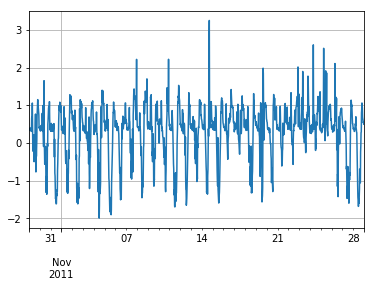

In [13]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

P_nl = P_load - P_sun
P_nl.plot()
plt.grid()

zoom

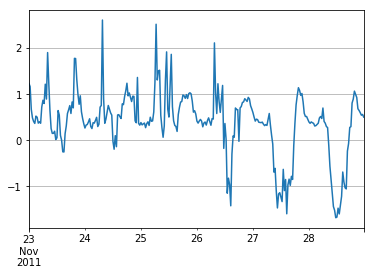

In [12]:
P_nl['2011-11-23':].plot()
plt.grid()

### Distribution

In [24]:
P_nl.describe()

count    1488.000000
mean        0.286681
std         0.724291
min        -1.991308
25%         0.043885
50%         0.409000
75%         0.718981
max         3.252077
dtype: float64

Text(0.5,0,'$P_{nl}= P_{load} - P_{sun}$ (kW)')

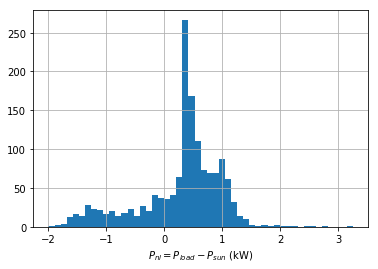

In [25]:
P_nl.hist(bins=50)
plt.xlabel('$P_{nl}= P_{load} - P_{sun}$ (kW)');

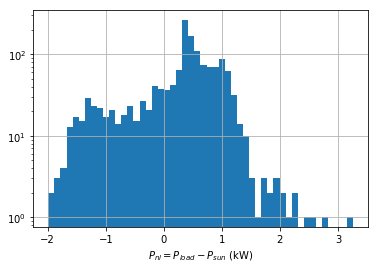

In [26]:
P_nl.hist(bins=50)
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel('$P_{nl}= P_{load} - P_{sun}$ (kW)');

### Temporal structure, persistence

In [ ]:
def acf(x, lag_max):
    s = x.var()
    cov_xx = [x.cov(x.shift(h)) for h in range(lag_max+1)]
    return pd.Series(cov_xx)/s

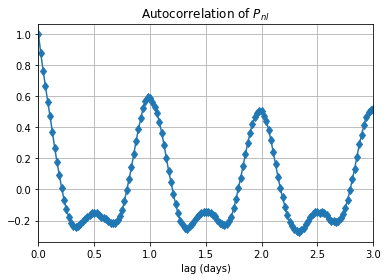

In [66]:
P_nl_acf = acf(P_nl, 48*3)
P_nl_acf.index = np.arange(len(P_nl_acf))*dt/24
ax = P_nl_acf.plot(style='-d')

ax.set(
    title = 'Autocorrelation of $P_{nl}$',
    xlabel = 'lag (days)'
)
plt.grid()

Looking at the autocorrelation, there is clearly a daily persistence.

* because the daily periodic pattern ?
* or because of a persistence between days?

#### Daily average, to study the persitence between days

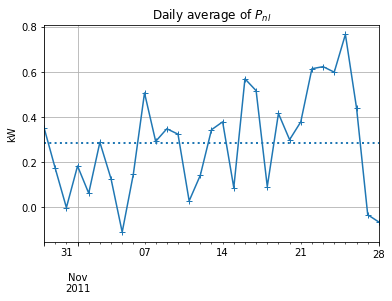

In [71]:
P_nl_d = P_nl.resample('1D').mean()
ax = P_nl_d.plot(style='+-')
plt.axhline(P_nl.mean(), ls=':', lw=2)

ax.set(
    title = 'Daily average of $P_{nl}$',
    ylabel = 'kW'
)
plt.grid()

44 % correlation between two consecutive days. So there is a medium persistence between consecutive days.

In [70]:
P_nl_d.corr(P_nl_d.shift())

0.4386780899122158

however, the precision of this number is small, because there are only 30 days. Cf. 95% the significence level

In [75]:
acf_sig = 1.96/np.sqrt(len(P_nl_d))
acf_sig

0.3520263919724788

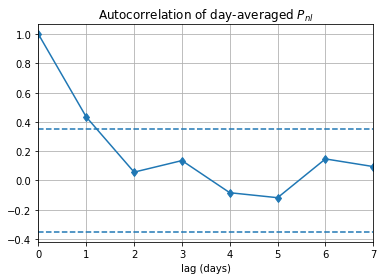

In [76]:
P_nl_d_acf = acf(P_nl_d, 7)
ax = P_nl_d_acf.plot(style='-d')
ax.axhline(acf_sig, ls='--')
ax.axhline(-acf_sig, ls='--')
ax.set(
    title = 'Autocorrelation of day-averaged $P_{nl}$',
    xlabel = 'lag (days)'
)
plt.grid()

As a conclusion, the daily pattern may explain most of the acf pattern of  $P_{nl}$

## Daily pattern, deseasonalization

nb: some code here pasted from "Ausgrid Solar Home/Customer exploration" notebook.

In [ ]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

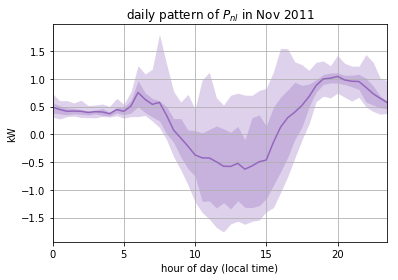

In [96]:
c = 'tab:purple'
P_byhod = P_nl.groupby(hod)
P_dm = P_byhod.mean()

ax = P_dm.plot(c=c)
ax.fill_between(P_dm.index, P_byhod.quantile(.05), P_byhod.quantile(.95),
                alpha=0.3, color=c, lw=0)
ax.fill_between(P_dm.index, P_byhod.quantile(.25), P_byhod.quantile(.75),
                alpha=0.3, color=c, lw=0)
ax.set(
    title='daily pattern of $P_{nl}$ in Nov 2011',
    ylabel='kW',
    xlabel='hour of day (local time)'
)
ax.grid()

In [98]:
quantiles = np.linspace(0.05, 0.95, 19)
quantiles

def daily_pattern(ts):
    '''compute statistics for each hour of the day (min, max, mean and quantiles)
    of the time series `ts`
    
    returns DataFrame with columns 'mean','min', 'qXX'..., 'max'
    and rows being the hours of the day between 0. and 24.
    '''
    dstats = pd.DataFrame({
        'q{:02.0f}'.format(q*100) : ts.groupby(by=hod).quantile(q)
        for q in quantiles
    })
    dstats.insert(0, 'min',  ts.groupby(by=hod).min())
    dstats.insert(0, 'mean', ts.groupby(by=hod).mean())
    dstats['max'] = ts.groupby(by=hod).max()
    return dstats

In [100]:
def plot_daily_pattern(dstats, title):
    fig, ax = plt.subplots(1,1)
    
    q_names = [c for c in dstats.columns if c.startswith('q')]
    
    dstats[q_names[:9]].plot(ax=ax, color='tab:blue', lw=0.5)
    dstats['q50'].plot(ax=ax, color='k')
    dstats[q_names[11:]].plot(ax=ax, color='tab:red', lw=0.5)
    dstats['min'].plot(ax=ax, color='tab:blue', label='min')
    dstats['max'].plot(ax=ax, color='tab:red')
    dstats['mean'].plot(ax=ax, color='k', lw=6, alpha=0.5)
    plt.legend(ax.lines[-3:], ['min', 'max', 'mean']);
    
    ax.set(
        xlabel='hour of the day',
        ylabel='Power (kW)',
        title=title)
    fig.tight_layout()
    return fig, ax

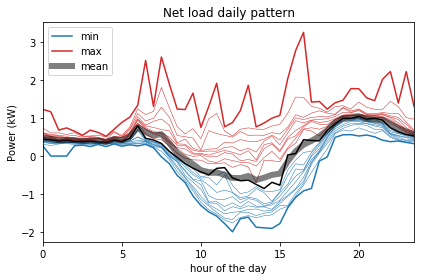

In [101]:
fig, ax = plot_daily_pattern(daily_pattern(P_nl),
    title='Net load daily pattern')